The goal of this kernel is to create some of the basic supervised learning algorithm from scratch, understand it using a lower dimensional dataset and then implement them to Predict the sentiments of a set of Amazon customer reviews on Food products.

We will be defining a few of the most basic and fundamental type linear classifier, i.e. perceptron, average perceptron and Stochastic gradient method and comparing them based on their performance on test data. 

These are binary classifiers and we will use them to classify between $y \in \{1,-1\}$.

In the end, we will do some parameter tuning to see which hyperparameters are best suited for our chosen algorithm.

Steps followed

1. Importing the libraries.
2. Building Models

    - 2.1 Perceptron algorithm
    - 2.2 Average Perceptron algorithm
    - 2.3 Pegasos algorithm
    
    
3. Loading the data
4. Data transformation
5. Label Classification and Accuracy
6. Model Tuning
7. Classifying the test data
8. Feature Engineering


### 1. Importing Libraries

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pylab
from string import punctuation, digits

In [137]:
pylab.rc('figure', figsize=(10,7))


## 2. Building Models
### 2.1 Perceptron algorithm:
The Perceptron algorithm is the simplest type of artificial neural network.
It is a model of a single neuron that can be used for two-class classification problems and provides the foundation for later developing much larger networks. 
- The model takes the training data and some random initial weights (often 0) as input.
- It then goes through each example/row of data and make an update to the parameters if there is a misclassification.
- If there exist a linear classifier that correctly classifies the examples, then perceptron algorithm will definitely find that. 

Further readings: http://ciml.info/dl/v0_8/ciml-v0_8-ch03.pdf

An example is considered misclassified when:

$$y^{(i)}(\theta.x^{(i)}+\theta_0)\leq 0 $$
where,

 $ x^{(i)} $ is an example vector
 
 $y^{(i)}$ is the example label
 
 $\theta$ and $\theta_0$ are the parameters
 
 
Once there is a misclassification the algorithm will update the parameters as per the following rule:

if $$y^{(i)}(\theta.x^{(i)}+\theta_0)\leq 0 $$ then
        
$$\theta=\theta + y^{(i)} x^{(i)}$$
$$\theta_0=\theta_0 + y^{(i)}$$

##### Yes, as simple as that! 

Now, we need to run this algorithm over T epochs to get our final result. So lets get started.


In [138]:
def perceptron_single_step_update(feature_vector,label,current_theta,current_theta_0):
    
    if(np.dot(label,(np.dot(current_theta,feature_vector.transpose())+current_theta_0))<=0):
        
        current_theta=current_theta+np.dot(label,feature_vector)
        current_theta_0=current_theta_0+label
        
    return (current_theta,current_theta_0)

In [139]:
def perceptron(feature_matrix, labels, T):

    update=(np.zeros(feature_matrix.shape[1]),0)
    for t in range(T):
        for i in range(feature_matrix.shape[0]):

            update=perceptron_single_step_update(feature_matrix[i],labels[i],update[0],update[1])

    return(update)

###### Let's define loss function to check our models performance.

A loss is incurred whenever the points cross the decision boundary (marginal boundary in fact) and is given by:

$$loss = 1-y^{(i)}(\theta.x^{(i)}+\theta_0) $$

Also a function for a quick visualisation of our linear classifier.

In [140]:
def hinge_loss_single(feature_vector, label, theta, theta_0):

    y = np.dot(theta, feature_vector) + theta_0
    loss = max(0.0, 1 - y * label)
    return loss
    raise NotImplementedError
    
def hinge_loss_full(feature_matrix, labels, theta, theta_0):

    loss=0
    for vec, y in zip(feature_matrix, labels):
        loss=loss+hinge_loss_single(vec,y,theta,theta_0)
    
    return (loss/len(labels))
 

In [141]:
def plot_classifier(theta,theta_0): # to visualise our model
    good=toy_data[0]==1
    plt.scatter(toy_data[1][good],toy_data[2][good],c='blue',alpha=0.8,label='Classified True')
    plt.scatter(toy_data[1][~good],toy_data[2][~good],c='r',alpha=0.8,label='Classified False')

    xmin,xmax=plt.axis()[:2]
    
    x=np.linspace(xmin,xmax)
    y = -(theta[0]*x + theta_0) / (theta[1] + 1e-16)
    plt.plot(x,y,label='Classifier',lw=2)
    plt.xlabel("Values of x1")
    plt.ylabel("Values of x2")
    plt.title("Linear classifier for a 2-d feature vector")
    plt.legend()
    

###### Now that we have all the tools we need, let's see how our model works by importing some data. 

In [149]:
toy_data=np.loadtxt("toy_data.tsv",delimiter='\t',unpack=True)
toy_label,toy_feature= toy_data[0],toy_data[[1,2]]

200

Average hinge loss for Perceptron algorithm is 1.0188


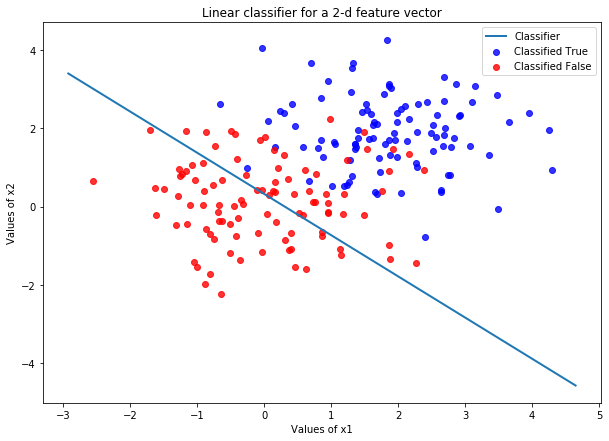

In [143]:
theta,theta_0=perceptron(toy_feature.transpose(),toy_label,15)
plot_classifier(theta,theta_0)
print(f"Average hinge loss for Perceptron algorithm is {hinge_loss_full(toy_feature.transpose(),toy_label,theta,theta_0):.4f}")

Oops!! That's a lot of points misclassified there and hence a high loss. How could we try to reduce that?
One important thing here to consider is the order in which the updates are performed. We are simply looping over the algorithm in a constant order, which is not a good idea.

Consider what the perceptron algorithm would do on a data set that consisted of 500 positive examples followed by 500 negatives
examples. After seeing the first few positive examples (maybe five),it would likely decide that every example is positive, and would stop learning anything. It would do well for a while (next 495 examples), until it hit the batch of negative examples. Then it would take a while (maybe ten examples) before it would start predicting everything as negative. By the end of one pass through the data, it would really only have learned from a handful of examples (fifteen in this case).

Hence, we need to shuffle the orders in which the examples are learned and updated before each epoch. 


In [144]:
def get_order(n_samples):
    try:
        with open(str(n_samples) + '.txt') as fp:
            line = fp.readline()
            return list(map(int, line.split(',')))
    except FileNotFoundError:
        random.seed(1)
        indices = list(range(n_samples))
        random.shuffle(indices)
        return indices

In [145]:
def perceptron_stochaistic(feature_matrix, labels, T):

    update=(np.zeros(feature_matrix.shape[1]),0)
    for t in range(T):
        for i in get_order(feature_matrix.shape[0]):
            # 
            update=perceptron_single_step_update(feature_matrix[i],labels[i],update[0],update[1])

    return(update)

Great! Now lets see if we have done any better!

Average hinge loss for Perceptron algorithm is 0.4610


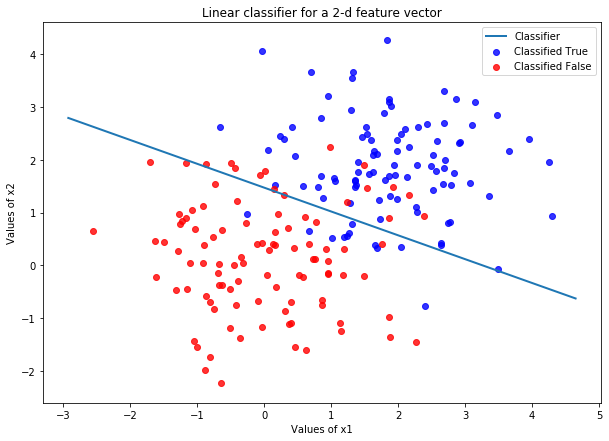

In [150]:
theta,theta_0=perceptron_stochaistic(toy_feature.transpose(),toy_label,15)
plot_classifier(theta,theta_0)
print(f"Average hinge loss for Perceptron algorithm is {hinge_loss_full(toy_feature.transpose(),toy_label,theta,theta_0):.4f}")

#### Much better indeed!

The loss is down to 0.4610 as there are a few inevitable points that are still misclassified.

### 2.2 Average Perceptron:

Let's now move to average perceptron algorithm.
The average perceptron will add a modification to the original perceptron algorithm: since the basic algorithm continues updating as the algorithm runs, nudging parameters in possibly conflicting directions, it is better to take an average of those parameters as the final answer. Every update of the algorithm is the same as before. The returned parameters  θ , however, are an average of the  θ s across the  n  steps:

$$\theta_{final}=\frac{1}{n}(\theta^{(1)}+\theta^{(2)}+\theta^{(3)}+...+\theta^{(n)}) $$

In [12]:
def average_perceptron(feature_matrix, labels, T):

    
    update=(np.zeros(feature_matrix.shape[1]),0) 
    theta_sum=np.array(update[0])
    theta_0_sum=update[1]
    count=0
    for t in range(T):
        for i in get_order(feature_matrix.shape[0]):
            update=perceptron_single_step_update(feature_matrix[i],labels[i],update[0],update[1])
            theta_sum=theta_sum+np.array(update[0])
            theta_0_sum=theta_0_sum+update[1]
            count=count+1
            
    avg_theta=theta_sum/count
    avg_theta_0=theta_0_sum/count
    
    return (avg_theta,avg_theta_0)

Average hinge loss for Average Perceptron algorithm is 0.3455


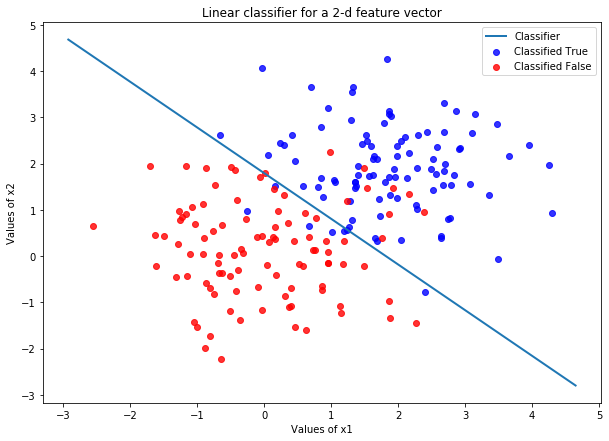

In [13]:
theta,theta_0=average_perceptron(toy_feature.transpose(),toy_label,15)
plot_classifier(theta,theta_0)
print(f"Average hinge loss for Average Perceptron algorithm is {hinge_loss_full(toy_feature.transpose(),toy_label,theta,theta_0):.4f}")

Okay, so we are able to reduce the loss even further by simply averaging out the paramameters. But things are not always that way simple.

 $$ Everything\:  should  \:be\: made\: as\: simple\: as\: possible,\: but\: no\: simpler.\: -\: Albert\: Einstein$$

### 2.3 Pegasos Algorithm:

Pegasos algorithm is simple stochastic gradient decent. The goal here is to minimize the cost function.
The cost function is combination of two things:
- Loss function: Defines the loss incurred due to points slipping into the marginal boundaries.
- Regularisation: It tries to keep the marginal boundaries as far as possible from the decision boundary in order to have a robust model.


$$ J(\theta,\theta_0)\: =\: \frac{1}{n} \sum{\underbrace{loss_h (y^{(i)}(\theta.x^{(i)}+\theta_0))}_{Hinge\: loss}\: +\:\underbrace{\frac{\lambda}{2}\parallel{\theta}\:\parallel}_{Regularisation}}  $$

- In order to update the parameters, the old parameters are tweaked in the negative direction of the derivative of the cost function. This in every pass takes us towards the minimum value of $\nabla J(\theta,\theta_0)$
- Unlike perceptron, the SGD will make an update in every step. Even if there is no loss incurred there will be changes due to the involvement of regularisation term.
- We are also going to include a step size (or learning rate) to make sure that we are not taking too large steps which might take us to somewhere the value of objective function is same or even higher.

In [14]:
def pegasos_single_step_update(feature_vector,label,L,eta,current_theta,current_theta_0):
    
    if(np.dot(label,(np.dot(current_theta,feature_vector.transpose())+current_theta_0))<=1):
        current_theta=current_theta*(1-eta*L)+eta*np.dot(label,feature_vector)
        current_theta_0=current_theta_0+eta*label
    else:
        current_theta=current_theta*(1-eta*L)
    
    return (current_theta,current_theta_0)


def pegasos(feature_matrix, labels, T, L):

    update=(np.zeros(feature_matrix.shape[1]),0) #why not just theta and theta zero
    count=0
    for t in range(T):
        
        for i in get_order(feature_matrix.shape[0]):
            count=count+1
            eta=1/np.sqrt(count)
            
            update=pegasos_single_step_update(feature_matrix[i],labels[i],L,eta,update[0],update[1])        
    return update

Average hinge loss for Pegasos algorithm is 0.2561


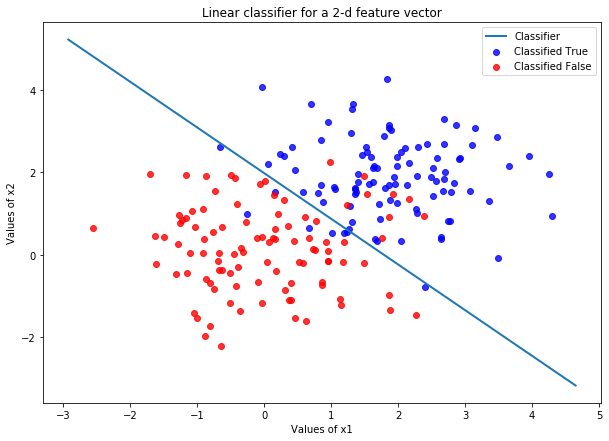

In [15]:
theta,theta_0=pegasos(toy_feature.transpose(),toy_label,T=15,L=0.1)
plot_classifier(theta,theta_0)
print(f"Average hinge loss for Pegasos algorithm is {hinge_loss_full(toy_feature.transpose(),toy_label,theta,theta_0):.4f}")

Looks like gradient decent is performing the best. But wait till we tune our models to get the maximum out of it.
Now that our models are ready, let's do the fun part. <b>Let's do some sentiment predictions on Amazon customer reviews on food products.</b>

### 3. Loading the datasets

In [100]:
train_data=pd.read_csv("reviews_train.tsv",delimiter='\t',engine ='python')
validation_data=pd.read_csv("reviews_val.tsv",delimiter='\t',engine ='python')
test_data=pd.read_csv("reviews_test.tsv",delimiter='\t',engine ='python')

In [101]:
train_data.head()

,sentiment,productId,userId,summary,text,helpfulY,helpfulN
0,-1,B000EQYQBO,A2JZVE0Y19VLL0,blue chips,The chips are okay Not near as flavorful as th...,0,0
1,-1,B000LKVHYC,A3NAKOMAS0I5L9,Bad even for 'healthy',"I had high hopes for this, but it was bad. Re...",0,0
2,-1,B003QRQRY2,ARBO3XW14MNGA,Alot of money for one can,I guess it's only one can since there is nothi...,1,1
3,-1,B008EG58V8,A1IQXGT4MJUYJ8,"The Box says ""OATMEAL SQUARES"" which I believe...","""Oatmeal Squares"" is in about the largest prin...",0,0
4,1,B004WZZY8M,A2TBL6WAZGXB9P,Delicious!,"I really enjoyed this flavor, this has a very ...",1,0


We are just interested in the `sentiments` which are the `labels` and the `text` which will be the `feature vector` for our model. However we need to convert the text into some sort of feature matrix, an array of `1s` and `0s`

In [102]:
train_text=train_data['text'].values
train_label=train_data['sentiment'].values

val_text=validation_data['text'].values
val_label=validation_data['sentiment'].values

test_text=test_data['text'].values
test_label=test_data['sentiment'].values

### 4. Transforming the data

- We will convert review texts into feature vectors using a bag of words approach. We start by compiling all the words that appear in a training set of reviews into a dictionary , thereby producing a list of  d  unique words.
- We can then transform each of the reviews into a feature vector of length  d  by setting the  ith  coordinate of the feature vector to  1  if the  ith  word in the dictionary appears in the review, or  0  otherwise.
- For instance, consider two simple documents “I love you 3000" and “love endgame". In this case, the dictionary is the set  {I;love;3000;you;endgame} , and the documents are represented as  (1;1;1;1;0)  and  (0;1;0;0;1).

In [126]:
def words_corpus(text_array):
    count=0
    dictionary={}
    for text in text_array:
        for c in punctuation + digits:
            text = text.replace(c, ' ' + c + ' ')
            
        
        for word in text.lower().split():
            if word not in dictionary.keys():
                dictionary[word]=len(dictionary)
    return dictionary

In [127]:
def text_to_feature(text_feature,dic):
    feature_matrix=np.zeros([len(text_feature),len(dic)])
   
    for i,text in enumerate(text_feature):
        for c in punctuation + digits:
            text = text.replace(c, ' ' + c + ' ')
            
        for word in text.lower().split():
            
            if word in dic:   ##For loop
                feature_matrix[i,dic[word]]=1
        
    return feature_matrix
    

In [128]:
dictionary=words_corpus(train_text)
train_feature_matrix=text_to_feature(train_text,dictionary)
val_feature_matrix=text_to_feature(val_text,dictionary)
test_feature_matrix=text_to_feature(test_text,dictionary)

print(f"Size of Training data: {train_feature_matrix.shape}")
print(f"Size of Validation data: {val_feature_matrix.shape}")
print(f"Size of Test data: {test_feature_matrix.shape}")

Size of Training data: (4000, 13234)
Size of Validation data: (500, 13234)
Size of Test data: (500, 13234)


In [129]:
dictionary2=words_corpus(val_text)
len(dictionary2)

4666

The feature vectors are now ready to be used. We see that there are `4000` examples to train our models on. We will validate our models and further tune them using `validation data` and finally when we have made decision on what model to use, we will feed in the `test data`, which our model hasn't seen before, and see how it performs.

Let's classify our data.

### Label Classification and Accuracy

In [130]:
def classify(feature_matrix, theta, theta_0):
    
    predictions=[]
    for i in range(len(feature_matrix)):
        
       if(np.dot(theta,feature_matrix[i].transpose())+theta_0)>0:
           
           predictions.append(1)
       else:
           predictions.append(-1)
           
    return np.array(predictions)


In [131]:
def accuracy(preds, targets):

    return (preds == targets).mean()

In [132]:
def classifier_accuracy(classifier,train_feature_matrix,val_feature_matrix,train_labels,val_labels,**kwargs):

    thetas=classifier(train_feature_matrix,train_labels,**kwargs)
        
    predictions_train=classify(train_feature_matrix,thetas[0],thetas[1])
    predictions_val=classify(val_feature_matrix,thetas[0],thetas[1])
    
    train_acc=accuracy(predictions_train,train_labels)
    val_acc=accuracy(predictions_val,val_labels)
    
    return (train_acc,val_acc)
  


In [133]:
train_accuracy_perc, val_accuracy_perc = classifier_accuracy(perceptron_stochaistic,train_feature_matrix,val_feature_matrix,train_label,val_label,T=15)
print("{:35} {:.4f}".format("Training accuracy for perceptron:", train_accuracy_perc))
print("{:35} {:.4f}".format("Validation accuracy for perceptron:", val_accuracy_perc))

Training accuracy for perceptron:   0.9825
Validation accuracy for perceptron: 0.7780


In [134]:
train_accuracy_avper, val_accuracy_avper = classifier_accuracy(average_perceptron,train_feature_matrix,val_feature_matrix,train_label,val_label,T=15)
print("{:35} {:.4f}".format("Training accuracy for Average perceptron:", train_accuracy_avper))
print("{:35} {:.4f}".format("Validation accuracy for Average perceptron:", val_accuracy_avper))

Training accuracy for Average perceptron: 0.9862
Validation accuracy for Average perceptron: 0.7980


In [112]:
train_accuracy_peag, val_accuracy_peag = classifier_accuracy(pegasos,train_feature_matrix,val_feature_matrix,train_label,val_label,T=15,L=0.01)
print("{:35}{:.4f}".format("Training accuracy for Pegasos:", train_accuracy_peag))
print("{:35} {:.4f}".format("Validation accuracy for Pegasos:", val_accuracy_peag))

Training accuracy for Pegasos:     0.9170
Validation accuracy for Pegasos:    0.8020


We can clearly see `Pegasos` is outperforming the two `perceptrons`.The other two algorithm are performing very good on training set, <b> Almost 99% accurate!!</b> but not so much on validation data. Where do you think the problem is? 

The issue is `Perceptron` is overfitting on the training data. It is following the examples too closely and picking up the noise. As a result it underperforms on validation data. `Pegasos` seem to be more robust and can handle different sets of training/test set better than others.

### 6. Model Tuning

Optimizing algoritinm is deciding what hyperparameters to choose. For perceptron we only have one hyperparameter that is number of epochs/passes, T. 

If we make many many passes over the training data, then the algorithm is likely to overfit. (This would be like studying too long for an exam and just confusing yourself.) On the other hand, going over the data only one time might lead to underfitting. 

Hence we have to choose a right value for T. There is no specific formula to abide by as such; we just have to see how the training and test loss changes with T and make an optimum choice.

In [113]:
def tune_param (train_fn,param_vals,train_feature,train_label,val_feature,val_label,**kwargs):
    train_accuracy=[]
    val_accuracy=[]
    
    for t in param_vals:
        theta,theta_0=train_fn(train_feature,train_label,t,**kwargs)
        train_predict=classify(train_feature,theta,theta_0)
        t_acc=accuracy(train_predict,train_label)
        train_accuracy.append(t_acc)
        
        val_predict=classify(val_feature,theta,theta_0)
        v_acc=accuracy(val_predict,val_label)
        val_accuracy.append(v_acc)
        print(f"For T = {t} ========== Training Accuracy = {t_acc:.4f} ========== Validation Accuracy = {v_acc:.4f}")
        
    return train_accuracy,val_accuracy

In [114]:
def plot_accuracy(algo_name, param_name, param_vals, acc_train, acc_val):
   
    
    plt.subplots()
    plt.plot(param_vals, acc_train, '-o')
    plt.plot(param_vals, acc_val, '-o')

  
    algo_name = ' '.join((word.capitalize() for word in algo_name.split(' ')))
    param_name = param_name.capitalize()
    plt.suptitle('Classification Accuracy vs {} ({})'.format(param_name, algo_name))
    plt.legend(['train','val'], loc='upper right', title='Partition')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy (%)')
    plt.show()


In [115]:
data = (train_feature_matrix, train_label, val_feature_matrix, val_label)
Ts = [5,10,15,20,25,30,40,50]

In [116]:
train_accuracy_per, val_accuracy_per=tune_param(perceptron_stochaistic,Ts,*data)
print(f"The best Parameter for Perceptron algorithm is T = {Ts[val_accuracy_per.index(max(val_accuracy_per))]} and maximum accuracy reached is {max(val_accuracy_per):.4f}")

For T = 5 ========== Training Accuracy = 0.8210 ========== Validation Accuracy = 0.7200
For T = 10 ========== Training Accuracy = 0.8157 ========== Validation Accuracy = 0.7160
For T = 15 ========== Training Accuracy = 0.9825 ========== Validation Accuracy = 0.7780
For T = 20 ========== Training Accuracy = 0.9635 ========== Validation Accuracy = 0.7860
For T = 25 ========== Training Accuracy = 0.9930 ========== Validation Accuracy = 0.7940
For T = 30 ========== Training Accuracy = 0.9960 ========== Validation Accuracy = 0.7780
For T = 40 ========== Training Accuracy = 1.0000 ========== Validation Accuracy = 0.7900
For T = 50 ========== Training Accuracy = 1.0000 ========== Validation Accuracy = 0.7900
The best Parameter for Perceptron algorithm is T = 25 and maximum accuracy reached is 0.7940


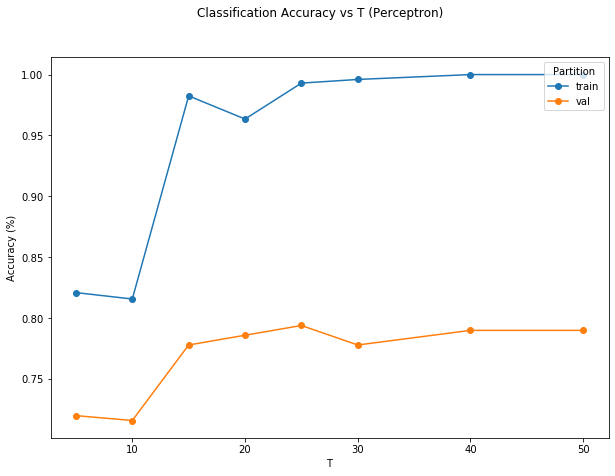

In [117]:
plot_accuracy("Perceptron","T",Ts,train_accuracy_per,val_accuracy_per)

In [118]:
train_accuracy_avgp, val_accuracy_avgp=tune_param(average_perceptron,Ts,*data)
print(f"The best Parameter for Average Perceptron algorithm is T = {Ts[val_accuracy_avgp.index(max(val_accuracy_avgp))]} and maximum accuracy reached is {max(val_accuracy_avgp):.4f}")

For T = 5 ========== Training Accuracy = 0.9460 ========== Validation Accuracy = 0.7920
For T = 10 ========== Training Accuracy = 0.9728 ========== Validation Accuracy = 0.7980
For T = 15 ========== Training Accuracy = 0.9862 ========== Validation Accuracy = 0.7980
For T = 20 ========== Training Accuracy = 0.9915 ========== Validation Accuracy = 0.8000
For T = 25 ========== Training Accuracy = 0.9955 ========== Validation Accuracy = 0.8000
For T = 30 ========== Training Accuracy = 0.9978 ========== Validation Accuracy = 0.7960
For T = 40 ========== Training Accuracy = 0.9990 ========== Validation Accuracy = 0.8000
For T = 50 ========== Training Accuracy = 0.9998 ========== Validation Accuracy = 0.7960
The best Parameter for Average Perceptron algorithm is T = 20 and maximum accuracy reached is 0.8000


In [119]:
plot_accuracy(Ts,train_accuracy_avgp,val_accuracy_avgp,"Average Perceptron")

TypeError: plot_accuracy() missing 1 required positional argument: 'acc_val'

In [122]:
train_accuracy_peg, val_accuracy_peg=tune_param(pegasos,Ts,*data,L=0.01)
print(f"\nThe best Parameter for Pegasos algorithm is T = {Ts[val_accuracy_peg.index(max(val_accuracy_peg))]} and maximum accuracy reached is {max(val_accuracy_peg):.4f}")

For T = 5 ========== Training Accuracy = 0.8942 ========== Validation Accuracy = 0.7800
For T = 10 ========== Training Accuracy = 0.9143 ========== Validation Accuracy = 0.7900
For T = 15 ========== Training Accuracy = 0.9170 ========== Validation Accuracy = 0.8020
For T = 20 ========== Training Accuracy = 0.9175 ========== Validation Accuracy = 0.7900
For T = 25 ========== Training Accuracy = 0.9185 ========== Validation Accuracy = 0.8060
For T = 30 ========== Training Accuracy = 0.9187 ========== Validation Accuracy = 0.8060
For T = 40 ========== Training Accuracy = 0.9185 ========== Validation Accuracy = 0.8040
For T = 50 ========== Training Accuracy = 0.9197 ========== Validation Accuracy = 0.8000

The best Parameter for Pegasos algorithm is T = 25 and maximum accuracy reached is 0.8060


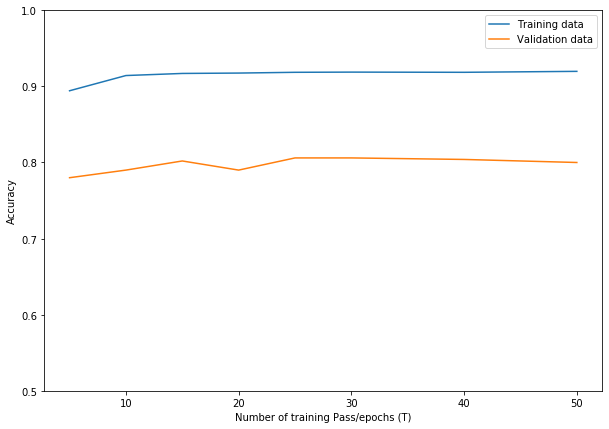

In [335]:
plot_accuracy(Ts,train_accuracy_peg,val_accuracy_peg,"Pegasos")

After analysing a number of `T` values we can say that `T=25` is an optimal solution and works the best for all the models. Right now we are concerned only on `Pegasos` as it permforms the best among all. Hence, we are going to use it to predict the `test` data.


### 7. Classifying the Test data

Finally, let's implement the best algoritm, coupled with the best parameters to predict the labels for the test data.

In [135]:
parameters=pegasos(train_feature_matrix,train_label,T=25,L=0.01)
pred=classify(test_feature_matrix,parameters[0],parameters[1])
acc=accuracy(pred,test_label)

print(f"The accuracy of the best fitted algorithm for Test data is : {acc:.4f}")

The accuracy of the best fitted algorithm for Test data is : 0.8020


Not bad. An acurracy of `0.8020` for complete new data set is pretty good. We can cleary see our model is robust.

### 7. Feature Engineering

- Sometimes, the way the data is represented can have a significant impact on the performance of a machine learning method. There are different angles to analyse the problem of how we want to represent the data in order to best capture the underlying function and get the best fit. We will try to implement one such technique and see if it changes anything.

- Objective is not to consider any `stop words` in our model training. Assumption is stop words don't add any significant value to the meaning of the sentence and hence are not likely to capture any sentiment.

- There is a list of `stop words` in the data which we can use directly. Feel free to add any missing word to the list.

- We are going to remove those words from our word dictionary and redefine all all feature vectors before training our best fitted model.


In [342]:
stopwords=pd.read_csv("stopwords.txt",header=None)
stopwords=stopwords[0].values

In [343]:
def word_pop(dic,word_list):
    for word in word_list:
        try:
            dictionary.pop(word)
        except:
            pass
    for i,word in enumerate(dic):
        dic[word]=i
    return dic

In [344]:
train_new=text_to_feature(train_text,new_dictionary)
val_new=text_to_feature(val_text,new_dictionary)
test_new=text_to_feature(test_text,new_dictionary)

In [345]:
new_dictionary=word_pop(dictionary,stopwords)

In [346]:
parameters=pegasos(train_new,train_label,T=25,L=0.01)
pred=classify(test_new,parameters[0],parameters[1])
acc=accuracy(pred,test_label)

print(f"The accuracy of the best fitted algorithm for test data is : {acc:.4f}")


The accuracy of the best fitted algorithm for Test data is : 0.8080


No big difference but we still see a 0.25% increase in accuracy of our model. Worth the effort!

In [154]:
results=pd.DataFrame(pred,columns=['Predicted_Labels'])
results.to_csv("submission.csv", index=False)

In [273]:
def losses_perceptron(feature_matrix,label,T):    
    losses=[]
    for t in T:
        theta,theta_0=perceptron_stochaistic(feature_matrix,label,t)
        losses.append(hinge_loss_full(feature_matrix,label,theta,theta_0))
    return losses

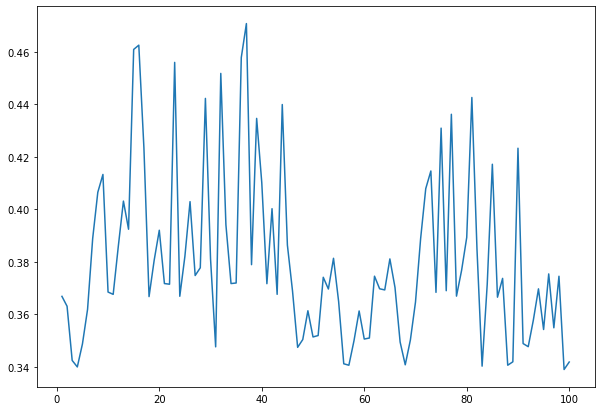

In [275]:
plt.plot(T,losses)

#### The difference between Gradient decent and Perceptron
- Perceptron is a error-driven algorithm. As long as it classifies the labels correctly it won't make any updates. It'll only make updates once it come across a wrongly classified label.
- Gradient decent on the other hand makes an update every step because of the regularization term. 

Source: 
http://ciml.info/dl/v0_8/ciml-v0_8-ch03.pdf
https://courses.edx.org/assets/courseware/v1/16f13f7ac37ae86ebe0372f2410bcec4/asset-v1:MITx+6.86x+1T2019+type@asset+block/resources_pegasos.pdf

The accuracy of the best fitted algorithm for Test data is : 0.8000
